In [19]:
import torch
#from torch.autograd import Variable
from torchvision import models, datasets, transforms
from torch.utils.data import SubsetRandomSampler, TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import random
#import cv2
import matplotlib.pyplot as plt
#import argparse
from PIL import Image
#from model_mnist import Basic_CNN

In [3]:
%config IPCompleter.greedy = True
#random_seed = 0 #As randomness is a key part of this method, we don't want a seed
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
import numpy as np
def get_train_data_stats(train_data):
    # use np.concatenate to stick all the images together to form a 1600000 X 32 X 3 array\
    x = np.concatenate([np.asarray(train_data[i][0]) for i in range(len(train_data))])
    print(x.shape)
    # calculate the mean and std along the (0, 1) axes
    train_mean = np.mean(x, axis=(0, 1))
    train_std = np.std(x, axis=(0, 1))
    print(train_mean, train_std)
    return train_mean, train_std

In [5]:
# load the training data
data_path = '~/IDS576/data'
train_data = datasets.MNIST(root=data_path, train=True, download=True)
train_mean, train_std = get_train_data_stats(train_data)

(1680000, 28)
33.318421449829934 78.56748998339798


In [6]:
print(train_mean/255, train_std/255)

0.1306604762738429 0.30810780385646264


In [7]:
'''normalize = transforms.Normalize(
    mean = train_mean/255, 
    std = train_std/255)'''

train_transform = transforms.Compose([
    transforms.ToTensor()
    ])
    
val_transform = transforms.Compose([   
    transforms.ToTensor()
    ])


In [8]:
# Download train and test data
data_path = '~/IDS576/data'
trainset = datasets.MNIST(root=data_path, train=True, download=True, transform=train_transform)
valset = datasets.MNIST(root=data_path, train=True, download=True, transform=val_transform)
testset = datasets.MNIST(root=data_path, train=False, download=True, transform=val_transform)

In [9]:
class MNIST(nn.Module):
    
    def __init__(self):
        super(MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 28, 3) #1 in channel, 28 filters, 3x3 filter size
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(28 * 13 * 13, 128)
        self.dropout = nn.Dropout(p=.2)
        self.fc2 = nn.Linear(128, 10)
                             
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 28 * 13 * 13) # Flattens from 28 13*13 (post pool, no pad) 1d 28*13*13 tensor
        x = F.relu(self.fc1(x)) # 28*13*13 inputs, 128 outputs
        x = self.dropout(x)
        x = F.relu(self.fc2(x)) # 128 inputs, 10 outputs to match num classes
        return x

1


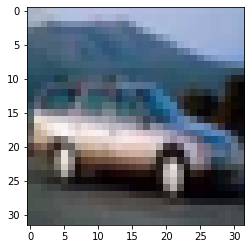

In [434]:
orig = trainset[4][0] #3x32x32
label = trainset[4][1]
img = denormalize(orig)
print(label)
plt.imshow(img.numpy().transpose(1,2,0))

In [22]:
def fgsm_batch(net, orig, eps=15):
    '''Given a pytorch CNN model, original image as tensor, and value for epsilon, create adversarial sample
    using fast gradient sign method (FGSM) described in arXiv:1412.6572v3'''
    # Create input tensor from original image, unsqeezing by a dim to account for model expected batch dim
    # float cast is likely not needed after normalization, but as float is required for cuda execution,
    # it's best to ensure float data
    inp = orig.float().clone().detach().to(device).requires_grad_(True)
    
    # Make prediction prior to attack to use in calulating gradients
    prior_out = net(inp)
    prior_pred = torch.argmax(prior_out)
    
    # Use prediction vector to compute loss and then compute gradients from loss to use in attack
    loss = criterion(prior_out, prior_pred.unsqueeze(0))
    loss.backward()
    
    # Actual FSGM method
    #print(orig.min(), orig.max())
    inp.data = inp.data + ((eps/255.0) * torch.sign(inp.grad.data))
    inp.data = inp.data.clamp(min=orig.min(), max=orig.max())
    #print(inp.min(), inp.max())
    '''
    # Predict on attack sample
    post_pred = torch.argmax(net(inp).data)
    
    # Create perturbation mask
    perturbation = torch.empty_like(orig)
    adv = inp.data.cpu()[0]
    perturbation = adv - orig'''
    
    return inp

In [61]:
def fgsm_sample(net, orig, eps=10):
    '''Given a pytorch CNN model, original image as tensor, and value for epsilon, create adversarial sample
    using fast gradient sign method (FGSM) described in arXiv:1412.6572v3'''
    # Create input tensor from original image, unsqeezing by a dim to account for model expected batch dim
    # float cast is likely not needed after normalization, but as float is required for cuda execution,
    # it's best to ensure float data
    inp = orig.unsqueeze(0).float().clone().detach().to(device).requires_grad_(True)
    
    # Make prediction prior to attack to use in calulating gradients
    prior_out = net(inp)
    prior_pred = torch.argmax(prior_out)
    
    # Use prediction vector to compute loss and then compute gradients from loss to use in attack
    loss = criterion(prior_out, prior_pred.unsqueeze(0))
    loss.backward()
    
    # Actual FSGM method
    #print(orig.min(), orig.max())
    inp.data = inp.data + ((eps/255.0) * torch.sign(inp.grad.data))
    inp.data = inp.data.clamp(min=orig.min(), max=orig.max())
    #print(inp.min(), inp.max())
    
    # Predict on attack sample
    post_pred = torch.argmax(net(inp).data)
    
    # Create perturbation mask
    perturbation = torch.empty_like(orig)
    adv = inp.data.cpu()[0]
    perturbation = adv - orig
    
    return inp, perturbation, prior_pred, post_pred

In [79]:
def denormalize(tensor):
    denorm_tensor = tensor.clone().detach()
    for t, mean, std in zip(denorm_tensor, train_mean, train_std):
        t.mul_(std).add_(mean)
    return denorm_tensor.int().clamp(min=0, max=255)

def visualize_attack(orig, inp, perturbation, prior_pred, post_pred, label):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    fig.suptitle(f'FGSM sample with epsilon = {eps}', y=.8)
    ax[0].set_title(f'True: {label}, Pred {prior_pred}')
    #ax[0].imshow(denormalize(orig).numpy().transpose(1,2,0))
    ax[0].imshow(orig.numpy().squeeze(0), cmap='gray')
    ax[1].set_title(f'Perturbation')
    #ax[1].imshow(denormalize(perturbation).numpy().transpose(1,2,0))
    ax[1].imshow(perturbation.numpy().squeeze(0), cmap='gray')
    ax[2].set_title(f'Adv Pred: {post_pred}')
    #ax[2].imshow(denormalize(inp.cpu().squeeze()).numpy().transpose(1,2,0))
    ax[2].imshow(inp.cpu().squeeze().detach().numpy(), cmap='gray')

In [80]:
sample_idx = 100

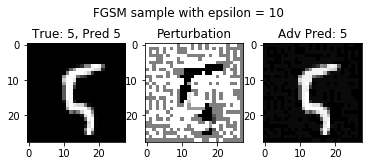

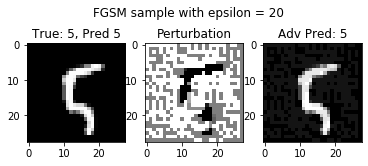

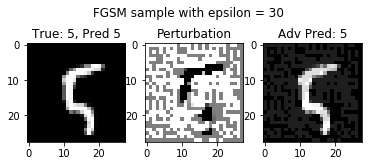

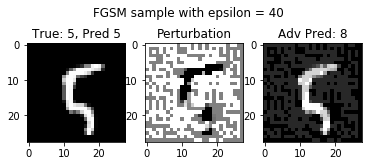

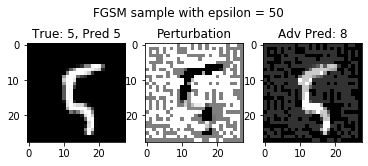

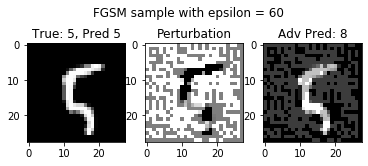

In [83]:
# FGSM vs MNIST with no RFN
num_samples = 1
trainlen = len(trainset)
eps_list = [10,20,30,40,50,60]

mnist_ref = MNIST()
mnist_ref.to(device)
mnist_ref.load_state_dict(torch.load(f'./models/MNIST_rfn_0.pth'))
mnist_ref.eval()

for i in range(num_samples):
    #sample_idx = int(random.random()*trainlen)
    for eps in eps_list:
        orig = trainset[sample_idx][0] #3x32x32
        label = trainset[sample_idx][1]
        inp, perturbation, prior_pred, post_pred = fgsm_sample(mnist_ref, orig, eps=eps)
        visualize_attack(orig, inp, perturbation, prior_pred, post_pred, label)


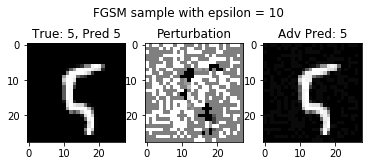

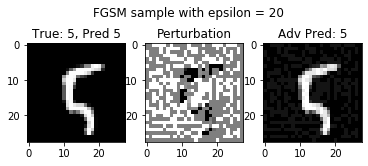

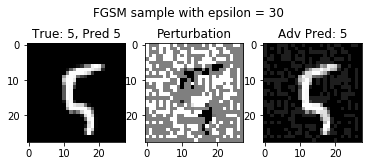

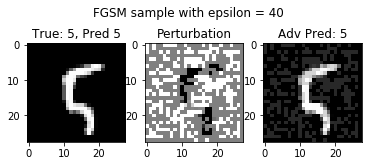

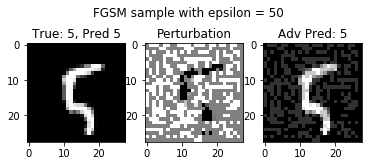

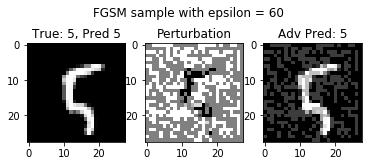

In [87]:
# FGSM vs MNIST with RFN
num_samples = 1
trainlen = len(trainset)
eps_list = [10,20,30,40,50,60]
mu = 0.3

mnist_ref = MNIST()
mnist_ref.to(device)
mnist_ref.load_state_dict(torch.load(f'./models/MNIST_rfn_{mu}.pth'))
mnist_ref.eval()
rfn_wrapper = RFN(mnist_ref, mu=mu, sigma=0, rfn_flag=True)
rfn_wrapper.to(device)

for i in range(num_samples):
    #sample_idx = int(random.random()*trainlen)
    
    for eps in eps_list:
        orig = trainset[sample_idx][0] #3x32x32
        label = trainset[sample_idx][1]
        inp, perturbation, prior_pred, post_pred = fgsm_sample(rfn_wrapper, orig, eps=eps)
        visualize_attack(orig, inp, perturbation, prior_pred, post_pred, label)

In [29]:
def evaluate(net, dataloader, eps=15, adv=False):
    correct = 0
    count = 0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        if adv:
            inputs = fgsm_batch(net, inputs, eps = eps)
        preds = net(inputs)
        if torch.argmax(preds) == labels:
            correct += 1.0
        count += 1.0
        if not i % 5000:
            print(f'Sample: {i}, Running Accuracy: {(correct/count):5.3f}')
    acc = correct/count
    print(f'Accuracy over {int(count)} samples: {acc:5.3f}')
    return acc
        

In [36]:
# Create accuracy dictionary
from collections import defaultdict
accs_no_fsgm = defaultdict(list)
accs_fsgm = defaultdict(list)

In [37]:
epsilons = np.array([10, 20, 30, 40])
epsilons/255

array([0.03921569, 0.07843137, 0.11764706, 0.15686275])

In [39]:
# load MNIST models
train_dl = DataLoader(trainset, batch_size=1)

rfn_mu_vals = [0, .1, .2, .3, .4, .5]

#epsilons = [10, 20, 30, 40]
epsilons = [40]

for eps in epsilons:
    for adv in [False, True]:
        for i, mu in enumerate(rfn_mu_vals):
            mnist_rfn = MNIST()
            rfn_wrapper = RFN(mnist_rfn, mu=mu, sigma=0, rfn_flag=True)
            mnist_rfn.load_state_dict(torch.load(f'./models/MNIST_rfn_{mu}.pth'))
            mnist_rfn.to(device)
            mnist_rfn.eval()
            criterion = nn.CrossEntropyLoss()
            if adv:
                print(f'Evaluate MNIST RFN at epsilon={eps}, mu={mu}:')
                accs_fsgm[mu] = evaluate(rfn_wrapper, train_dl, eps=eps, adv=adv)
            else:
                print(f'Evaluate MNIST RFN without FSGM, mu={mu}:')
                accs_no_fsgm[mu] = evaluate(rfn_wrapper, train_dl, eps=eps, adv=adv)

Evaluate MNIST RFN without FSGM, mu=0:
Sample: 0, Running Accuracy: 1.000
Sample: 5000, Running Accuracy: 0.985
Sample: 10000, Running Accuracy: 0.985
Sample: 15000, Running Accuracy: 0.984
Sample: 20000, Running Accuracy: 0.985
Sample: 25000, Running Accuracy: 0.984
Sample: 30000, Running Accuracy: 0.984
Sample: 35000, Running Accuracy: 0.983
Sample: 40000, Running Accuracy: 0.984
Sample: 45000, Running Accuracy: 0.983
Sample: 50000, Running Accuracy: 0.983
Sample: 55000, Running Accuracy: 0.983
Accuracy over 60000 samples: 0.983
Evaluate MNIST RFN without FSGM, mu=0.1:
Sample: 0, Running Accuracy: 1.000
Sample: 5000, Running Accuracy: 0.979
Sample: 10000, Running Accuracy: 0.977
Sample: 15000, Running Accuracy: 0.977
Sample: 20000, Running Accuracy: 0.978
Sample: 25000, Running Accuracy: 0.977
Sample: 30000, Running Accuracy: 0.977
Sample: 35000, Running Accuracy: 0.977
Sample: 40000, Running Accuracy: 0.977
Sample: 45000, Running Accuracy: 0.977
Sample: 50000, Running Accuracy: 0.97

In [58]:
print(f'MU\tMNIST\tFSGM eps=40')

for mu in rfn_mu_vals:
    print(f'{mu}\t{accs_no_fsgm[int(10*mu)]:5.3}\t{accs_fsgm[int(10*mu)]:5.3}')
    

MU	MNIST	FSGM eps=40
0	0.983	0.559
0.1	0.976	0.629
0.2	0.968	0.687
0.3	0.955	0.731
0.4	0.936	0.758
0.5	0.909	0.765


In [54]:
for k,v in accs_no_fsgm.items():
    print(k,v)
for k,v in accs_fsgm.items():
    print(k,v)

0 0.983
1 0.9764833333333334
2 0.96845
3 0.95525
4 0.9361666666666667
5 0.9090666666666667
0.1 []
0.2 []
0.3 []
0.4 []
0.5 []
0 []
0.1 []
0.2 []
0.3 []
0.4 []
0.5 []
0 0.5592666666666667
1 0.6287833333333334
2 0.6867833333333333
3 0.7313333333333333
4 0.7579
5 0.7648666666666667
0.1 []
0.2 []
0.3 []
0.4 []
0.5 []


In [805]:

eval(basicnet, train_dl, adv=False)

Sample: 0, Running Accuracy: 1.000
Sample: 5000, Running Accuracy: 0.509
Sample: 10000, Running Accuracy: 0.505
Sample: 15000, Running Accuracy: 0.505
Sample: 20000, Running Accuracy: 0.501
Sample: 25000, Running Accuracy: 0.503
Sample: 30000, Running Accuracy: 0.506
Sample: 35000, Running Accuracy: 0.504
Sample: 40000, Running Accuracy: 0.504
Sample: 45000, Running Accuracy: 0.504
Accuracy over 50000 samples: 0.505


In [812]:
eval(basicnet, train_dl, adv=True)

Sample: 0, Running Accuracy: 0.000
Sample: 5000, Running Accuracy: 0.366
Sample: 10000, Running Accuracy: 0.371
Sample: 15000, Running Accuracy: 0.371
Sample: 20000, Running Accuracy: 0.373
Sample: 25000, Running Accuracy: 0.374
Sample: 30000, Running Accuracy: 0.376
Sample: 35000, Running Accuracy: 0.374
Sample: 40000, Running Accuracy: 0.374
Sample: 45000, Running Accuracy: 0.375
Accuracy over 50000 samples: 0.375


In [813]:
eval(rfnnet, train_dl, adv=False)

Sample: 0, Running Accuracy: 0.000
Sample: 5000, Running Accuracy: 0.558
Sample: 10000, Running Accuracy: 0.558
Sample: 15000, Running Accuracy: 0.553
Sample: 20000, Running Accuracy: 0.552
Sample: 25000, Running Accuracy: 0.553
Sample: 30000, Running Accuracy: 0.554
Sample: 35000, Running Accuracy: 0.551
Sample: 40000, Running Accuracy: 0.550
Sample: 45000, Running Accuracy: 0.551
Accuracy over 50000 samples: 0.552


In [814]:
eval(rfnnet, train_dl, adv=True)

Sample: 0, Running Accuracy: 0.000
Sample: 5000, Running Accuracy: 0.465
Sample: 10000, Running Accuracy: 0.475
Sample: 15000, Running Accuracy: 0.476
Sample: 20000, Running Accuracy: 0.475
Sample: 25000, Running Accuracy: 0.478
Sample: 30000, Running Accuracy: 0.477
Sample: 35000, Running Accuracy: 0.476
Sample: 40000, Running Accuracy: 0.474
Sample: 45000, Running Accuracy: 0.474
Accuracy over 50000 samples: 0.474
